In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model,Input,layers
from tensorflow.keras.layers import Dense
from numpy import linalg as LA
# Set data type
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)


def vecterize(weights):
    '''
    transfer the weight tensor to a vector
        '''

    v = tf.reshape(weights[0], shape=[-1, 1])
    for weight in weights[1:]:
        v = tf.concat([v, tf.reshape(weight, shape=[-1, 1])], axis=0)
    return v


def tranfer_weight(vector, dim=1, nums=20):
    '''
    transfer the vector tensor to the weight tensor,default NN has 3 hiddlen layer with resnet structure.
    '''

    res = [0, 0, 0, 0, 0, 0, 0, 0]
    if dim == 2:
        res[0] = tf.reshape(vector[0:nums*2], [2, nums])
        vector = vector[nums:]
    elif dim == 1:
        res[0] = tf.reshape(vector[0:nums], [1, nums])#weights input - layer1
    res[1] = tf.reshape(vector[nums*1:nums*2], [nums])#bias 
    res[2] = tf.reshape(vector[nums*2:nums*(2+nums)], [nums, nums])#weights layer1-layer2
    res[3] = tf.reshape(vector[nums*(2+nums):nums*(3+nums)], [nums])#bias 
    res[4] = tf.reshape(vector[nums*(3+nums):nums*(2*nums+3)], [nums, nums])#weights layer2-layer3
    res[5] = tf.reshape(vector[nums*(2*nums+3):nums*(2*nums+4)], [nums])#bias 
    res[6] = tf.reshape(vector[nums*(2*nums+4):nums*(2*nums+5)], [nums, 1])#weights layer3-output
    res[7] = tf.reshape(vector[nums*(2*nums+5):], [1])#bias
    return res


## Try to solve heat equation $$u_t = u_{xx}$$ with I.C. $u(x,0)=cos(\frac{\pi}{2} x)$ and B.C. $u(-1,t)=u(1,t)=0, x \in [-1,1]$ The true solution is given by $$u(x,t)=e^{-\frac{\pi ^2}{4}t}cos(\frac{\pi}{2}x)$$

In [4]:
def heat_model(num_neurons_per_layer=20,activation='tanh',dim=1,Resnet=True):
    #Define the architecture of the neural network
    #Which only accept one input x and input u(x)
    activation = tf.keras.activations.get(activation)
    if dim==1:
        x_in = Input(shape=(1,))
    x1 = Dense(num_neurons_per_layer,activation=activation,kernel_initializer = 'glorot_normal')(x_in)
    x2 = Dense(num_neurons_per_layer, activation=activation,kernel_initializer='glorot_normal')(x1)
    x3 = Dense(num_neurons_per_layer, activation=activation,kernel_initializer='glorot_normal')(x2)

    if Resnet:
        x_add = layers.Add()([x3,x_in])
        x_out_ = Dense(1)(x_add)
    else:
        x_out_ = Dense(x3)

    if dim==1:
        x_out = (x_in*x_in-1)*x_out_#Imposing the boundary condition 0 on the bounday -1 and 1
    
    model = Model(inputs=x_in,outputs=x_out)
    return model



# Generate initial parameters for neural network. Try to minimize $$\int_{-1}^{1} |model(x;\theta _{0})-u(x,0)|^2 dx$$

In [5]:
model = heat_model()


In [6]:
from scipy.special import roots_legendre
import math
def f(x):
    pred = model(x)
    true = tf.cos(math.pi/2 * x)
    return tf.pow(pred-true,2)
def Gauss_Integral(f,N):
    """
    Compute the L_2 loss through Gauss Integral formula
    """
    x, w = roots_legendre(N)
    x = tf.expand_dims(tf.constant(x, dtype=DTYPE), 0)
    sum = 0

    for i in range(N):
        sum+=w[i]*f(x[:,i])
    return sum


In [129]:
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000, 7000, 15000, 30000], [1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
optim = tf.keras.optimizers.Adam(learning_rate=lr)
@tf.function
def train_initial():
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)
        loss = Gauss_Integral(f,30)
    g = tape.gradient(loss,model.trainable_variables)
    del tape
    optim.apply_gradients(zip(g, model.trainable_variables))
    return loss


In [16]:
path = "initial_weights.h5"
model.load_weights(path)
train_initial()


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[7.5542755e-07]], dtype=float32)>

In [5]:
model.save_weights('test_cases/test_case1/initial.h5')

In [229]:
for i in range(10000):
    train_initial()
train_initial()


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.9032084e-09]], dtype=float32)>

In [237]:
##Test the point wise error
x = tf.expand_dims(tf.constant(0.573, dtype=DTYPE), 0)
f(x)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.4643007e-09]], dtype=float32)>

In [230]:
model.save_weights('test_cases/test_case2/initial.h5')

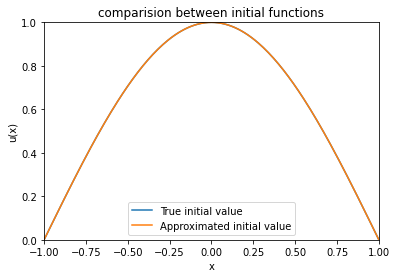

In [231]:
import matplotlib.pyplot as plt 
points = np.arange(-1,1.01,0.01)
x = tf.expand_dims(tf.constant(points, dtype=DTYPE), 1)
true = tf.cos(math.pi/2 * x).numpy()
pred = model(x).numpy()
plt.title("comparision between initial functions")
plt.xlabel('x')
plt.ylabel('u(x)')
plt.xlim(-1,1)
plt.ylim(0,1)
plt.plot(points,true)
plt.plot(points,pred)
plt.legend(['True initial value','Approximated initial value'])
plt.show()

# Next to generate $M(\theta )\dot{\theta} = G(\theta)$
## $$ G(\theta)= \int_{[-1,1]} \nabla_{\theta} model(x;\theta) \frac{\partial^2 model(x;\theta)}{\partial^2x}dx$$
## $$M(\theta) = \int_{[-1,1]} \nabla_{\theta} model(x;\theta) \otimes \nabla_{\theta} model(x;\theta)dx$$

In [41]:
@tf.function
def find_grad(model,x):
    #find gradient of \theta for given x
    #return in vectorized form
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)
        u = model(x)
    g = tape.gradient(u, model.trainable_variables)
    del tape
    return vecterize(g)


In [42]:
from scipy.special import roots_legendre
@tf.function
def find_G(model,N=10):
    #N is for Gauss-integration points
    x, w = roots_legendre(N)
    x = tf.expand_dims(tf.constant(x, dtype=DTYPE), 1)  
    temp = tf.constant(0,dtype=DTYPE)
    for i in range(N):
        t = x[i:i+1]
        #t = tf.reshape(x[i], [1, 1]) # otherwise shape(1,) will return a none gradient
        theta = find_grad(model,t) # the gradient of trainable variables of model 
        with tf.GradientTape(persistent=True) as gg:
            gg.watch(t)
            with tf.GradientTape(persistent=True) as g:
                g.watch(t)
                u = model(t)
            u_x = g.gradient(u,t)
            del g
        u_xx = gg.gradient(u_x,t)
        del gg
        temp+=w[i]*u_xx*theta
    return temp

    


In [43]:
@tf.function
def find_M(model,N):
    x, w = roots_legendre(N)
    x = tf.expand_dims(tf.constant(x, dtype=DTYPE), 1)
    temp = tf.constant(0, dtype=DTYPE)

    for i in range(N):
        theta = find_grad(model,x[i:i+1])
        temp += w[i]*tf.matmul(theta, tf.transpose(theta))

    return temp
    


## Use Different method to solve the ODE (Forward Euler, RK2, RK4)
##  FE:$$\theta_{fe}=\theta + dt*(M(\theta +\lambda I)^{-1} G(\theta))$$
## RK2:$$k_1=M(\theta +\lambda I)^{-1} G(\theta)$$    $$\theta_{rk2}=\theta + dt(M(\theta+ \frac{dt}{2} k_1) +\lambda I)^{-1} G(\theta+ \frac{dt}{2} k_1))$$
## RK4:$$k_1=M(\theta +\lambda I)^{-1} G(\theta)$$ $$ $$

In [44]:
path = "test_cases/test_case2/initial.h5"
model.load_weights(path)

def solve_fe(model,dt,lam,N):
    """
    return a list of vectorized thetas
    ------
    parameters

    dt: time gap
    lam: to make M+lam*I invertible
    N: Gauss-Integration points
    """
    ls = []
    q=vecterize(model.trainable_variables)
    N= q.shape[0]
    ls.append(q)
    n=int(1/dt)
    I = tf.eye(N)#Identity matrix
    for i in range(n):
        G = find_G(model,10)
        M = find_M(model,10)
        temp = tf.linalg.solve(M+lam*I,G)
        q+=dt*temp
        ls.append(q)
        model.set_weights(tranfer_weight(q))
        print ('yes')
    return ls



In [45]:
path = "test_cases/test_case2/initial.h5"
model.load_weights(path)


def solve_rk2(model, dt, lam, N):
    """
    return a list of vectorized thetas
    ------
    parameters

    dt: time gap
    lam: to make M+lam*I invertible
    N: Gauss-Integration points
    """
    ls = []
    q = vecterize(model.trainable_variables)
    N = q.shape[0]
    ls.append(q)
    n = int(1/dt)
    I = tf.eye(N)  # Identity matrix
    for i in range(n):
        G = find_G(model, 10)
        M = find_M(model, 10)
        k1 = tf.linalg.solve(M+lam*I, G)

        model.set_weights(tranfer_weight(q+dt/2*k1))
        G = find_G(model, 10)
        M = find_M(model, 10)
        k2 = tf.linalg.solve(M+lam*I, G)

        q+=dt*k2
        ls.append(q)
        model.set_weights(tranfer_weight(q))
    return ls


## Use Runge-kutta-4 method to solve 

In [49]:
path = "test_cases/test_case2/initial.h5"
model.load_weights(path)

def solve_rk4(model, dt, lam, N):
    """
    return a list of vectorized thetas
    ------
    parameters

    dt: time gap
    lam: to make M+lam*I invertible
    N: Gauss-Integration points
    """
    ls = []
    q = vecterize(model.trainable_variables)
    N = q.shape[0]
    ls.append(q)
    n = int(1/dt)
    I = tf.eye(N)  # Identity matrix
    for i in range(n):
        G = find_G(model, 10)
        M = find_M(model, 10)
        k1 = tf.linalg.solve(M+lam*I, G)

        model.set_weights(tranfer_weight(q+dt*k1/2))
        G = find_G(model,10)
        M = find_M(model,10)
        k2 = tf.linalg.solve(M+lam*I,G)

        model.set_weights(tranfer_weight(q+dt*k2/2))
        G = find_G(model, 10)
        M = find_M(model, 10)
        k3 = tf.linalg.solve(M+lam*I, G)

        model.set_weights(tranfer_weight(q+dt*k3))
        G = find_G(model, 10)
        M = find_M(model, 10)
        k4 = tf.linalg.solve(M+lam*I, G)

        q+=dt/6*(k1+2*k2+2*k3+k4)
        ls.append(q)
        model.set_weights(tranfer_weight(q))
        if i %100==0:
            print('yes')
    return ls


In [50]:
result = solve_rk4(model, 0.001, 0.001, 20)


yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


## Test

# Save the list to numpy 

In [243]:
import numpy as np
np.save('test_cases/test_case2/weights.npy',np.array(result))


In [15]:
# To load
test = np.load('test_case/test_case2/weights.npy').tolist()
result = tf.constant(test)

# Plot the 3D graph of the PDE

In [51]:
def predict(model,n,x):
    model.set_weights(tranfer_weight(result[n]))
    return model(tf.constant([x]))
    

In [52]:
predict(model,0,0)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.999976]], dtype=float32)>

In [53]:
N=1001
tspace = np.linspace(0,1,N)
xspace = np.linspace(-1,1,N)
T,X = np.meshgrid(tspace,xspace)



In [54]:
predictions = np.zeros((N,N))
for i in range(N):
    model.set_weights(tranfer_weight(result[i]))
    predictions[i] = tf.transpose(model(tf.transpose(tf.constant([xspace])))).numpy()


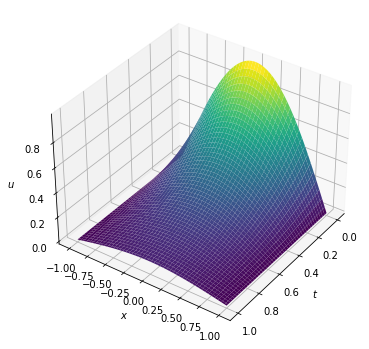

In [55]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, tf.transpose(predictions), cmap='viridis', )
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u$')
ax.view_init(35, 35)


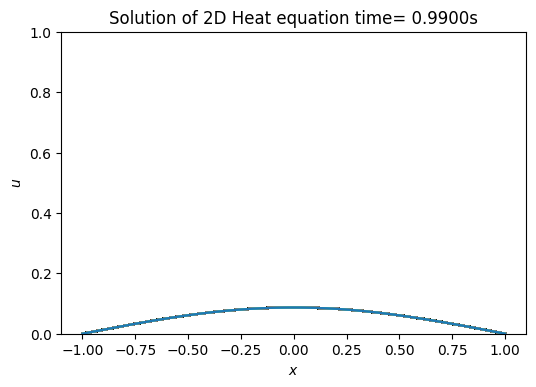

In [56]:
import matplotlib.animation as animation
from IPython.display import HTML


fig = plt.figure()
fig.set_dpi(100)
ax = fig.add_subplot()


def data(i):
    z = predictions[i*10]
    ax.clear()
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u$')
    ax.set_ylim(0, 1)
    im = ax.plot(X, z)
    #ax.view_init(35, 35)
    ax.set_title("Solution of 2D Heat equation time= {:.4f}s".format(0.01*i))


ani = animation.FuncAnimation(fig, data, frames=100)

HTML(ani.to_jshtml())


In [21]:
0.012/0.001

12.0

In [24]:
math.pi

3.141592653589793

# Compute the L2 error

In [251]:
def L2(t,dt,N):
    #dt time gap, we only compute the value if t at the grid points
    x, w = roots_legendre(N)
    x = tf.expand_dims(tf.constant(x, dtype=DTYPE), 1)
    n = int(t/dt)
    model.set_weights(tranfer_weight(result[n]))
    temp=0
    for i in range(N):
         temp+=w[i]*tf.pow(model(x[i:i+1])-math.pow(math.e,-math.pi*math.pi/4*t)*math.cos(x[i]*math.pi/2),2)
    return temp.numpy()[0][0]


In [252]:
error_ls = []
for i in range(101):
    error_ls.append(L2(i*0.01,0.001,10))

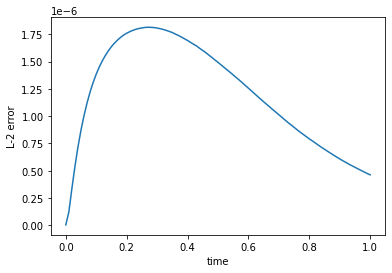

In [253]:
import matplotlib.pyplot as plt
temp = np.linspace(0, 1, 101)
plt.figure()
plt.xlabel('time')
plt.ylabel('L-2 error')
plt.plot(temp, error_ls)
plt.savefig('L_2 error for heat equation.png')
